In [1]:
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir,os.pardir))
os.chdir(parent_dir)

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from vae_earlystopping import EarlyStopping
from model1.m2 import Model2
from loss1.l2 import loss2
from kl_divergence.sigmoid import gamma_sigmoid


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_loader = torch.load('torch_1/pre_retrain_loader_min.pt',weights_only=False)
val_loader = torch.load('torch_1/pre_reval_loader_min.pt',weights_only=False)
test_loader = torch.load('torch_1/pre_retest_loader_min.pt',weights_only=False)


In [5]:
x_sample,x2_sample, c_sample = next(iter(train_loader))
x_dim = x_sample.shape[1]
x2_dim = x2_sample.shape[1]
c_dim = c_sample.shape[1]
x_dim, x2_dim, c_dim

(23, 23, 15)

In [7]:
model = Model2(x_dim,x2_dim, c_dim,z_dim=8,z2_dim = 8).to(device)
early_stopping = EarlyStopping(patience=40,min_delta = 1e-9)
optimizer = optim.Adam(model.parameters(),lr = 1e-3, weight_decay=1e-5)
epochs = 600

In [ ]:
for epoch in range(1,epochs+1):
    gamma = gamma_sigmoid(epoch, gamma_max=0.1, center=300,steepness=0.3)
    model.train()
    t_loss = 0
    for x, x2, c in train_loader:
        x,x2,c = x.to(device),x2.to(device),c.to(device)
        bce_logit, x_hat,mu,logvar,mu2,logvar2 = model(x,x2,c)
        loss_dict = loss2(bce_logit, x_hat, x, x2, mu, logvar, mu2, logvar2, a=1, b=1, c=gamma, d=gamma)
        optimizer.zero_grad()
        loss_dict['loss'].backward()
        optimizer.step()
        t_loss +=loss_dict['loss'].item()
    

    model.eval()
    v_loss = 0
    x_true_all,x_pred_all,x_hat_all = [],[],[]
    with torch.no_grad():
        for v_x, v2_x, v_c in val_loader:
            v_x,v2_x, v_c = v_x.to(device),v2_x.to(device), v_c.to(device)
            v_bce_logit,v_x_hat,v_mu,v_logvar,v2_mu,v2_logvar = model(v_x, v2_x, v_c)
            loss_dict = loss2(v_bce_logit, v_x_hat, v_x,v2_x, v_mu,v_logvar,v2_mu,v2_logvar, a=1, b=1, c=gamma, d=gamma)
            v_loss +=loss_dict['loss'].item()
    avg_train_loss = t_loss/len(train_loader)
    avg_val_loss = v_loss/len(val_loader)

    if epoch % 20 ==0  or epoch ==2:
        print(f'Epoch [{epoch}/{epochs}]|Train:{avg_train_loss:.4f} |Val:{avg_val_loss:.4f}')
    if early_stopping(avg_val_loss,model):
        break


TypeError: gamma_sigmoid() got an unexpected keyword argument 'warmup_epochs'

In [ ]:
import joblib
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error
x_scaler = joblib.load('torch_1/min_x_scaler.pkl')

In [ ]:
early_stopping.load_best_model(model)
model.eval()

x_true = []
x_pred = []
## 최적의 model의 z리스트와 라벨 리스트
z_list = []
with torch.no_grad():
    for x_t,x2_t, c_t in test_loader:
        x_t,x2_t, c_t = x_t.to(device),x2_t.to(device), c_t.to(device)
        bce_logit, x_hat,z_mu,z_logvar,z2_mu,z2_logvar = model(x_t,x2_t,c_t)
        x_true.append(x2_t.cpu().numpy())
        x_pred.append(x_hat.cpu().numpy())
all_x_true = np.vstack(x_true)
all_x_hat = np.vstack(x_pred)

Restored best model with loss: 0.845400


In [ ]:
x_true_raw = x_scaler.inverse_transform(all_x_true)
x_hat_raw = x_scaler.inverse_transform(all_x_hat)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
x_true = all_x_true.flatten()
x_pred = all_x_hat.flatten()
rmse = np.sqrt(mean_squared_error(x_true,x_pred))
r2 = r2_score(x_true,x_pred)
history = {'RMSE':round(float(rmse),4),'R2':round(float(r2),4)}
history

{'RMSE': 0.0441, 'R2': 0.6849}

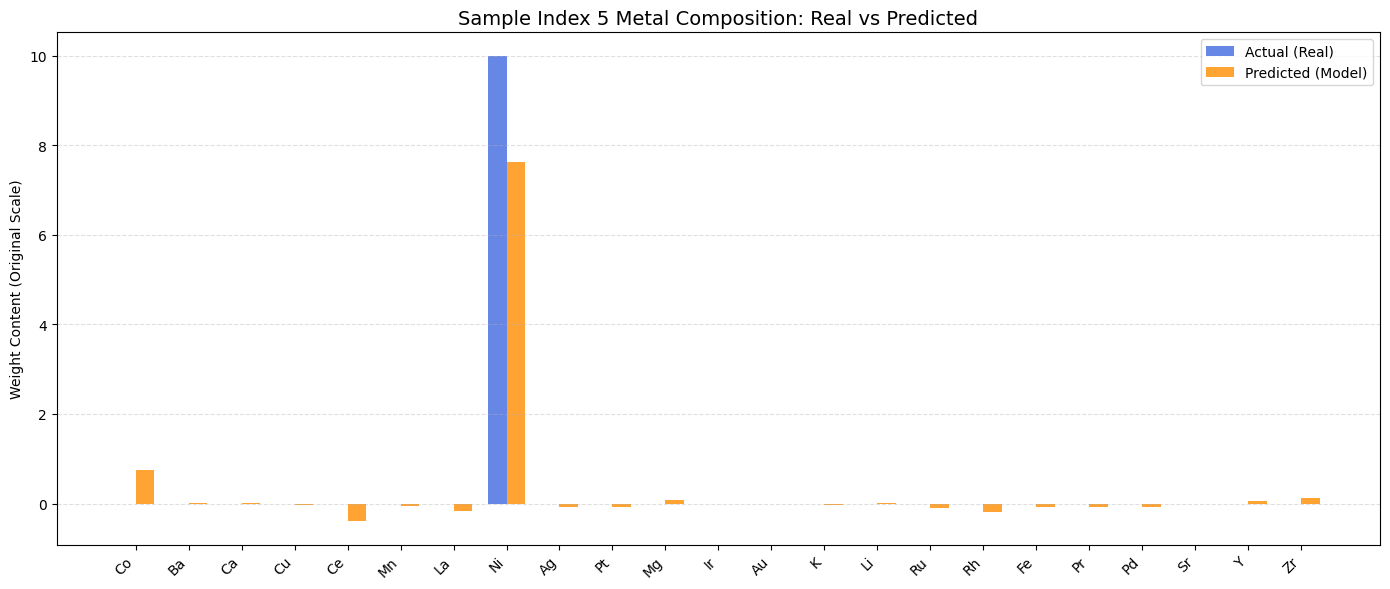

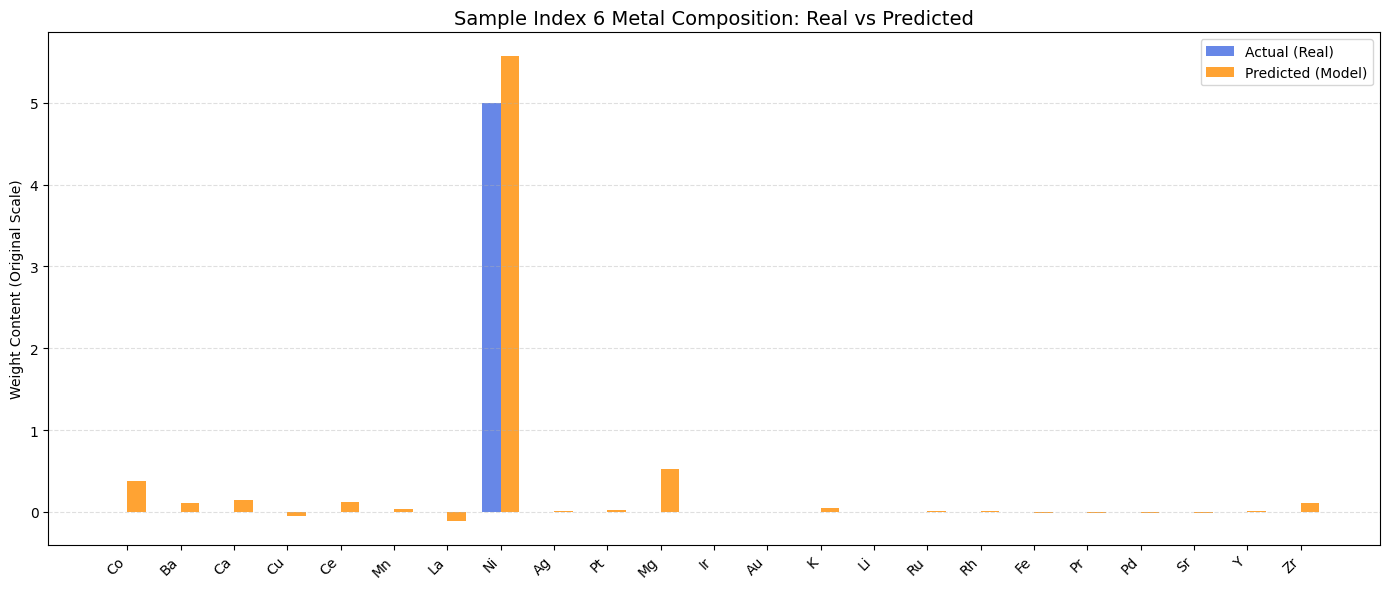

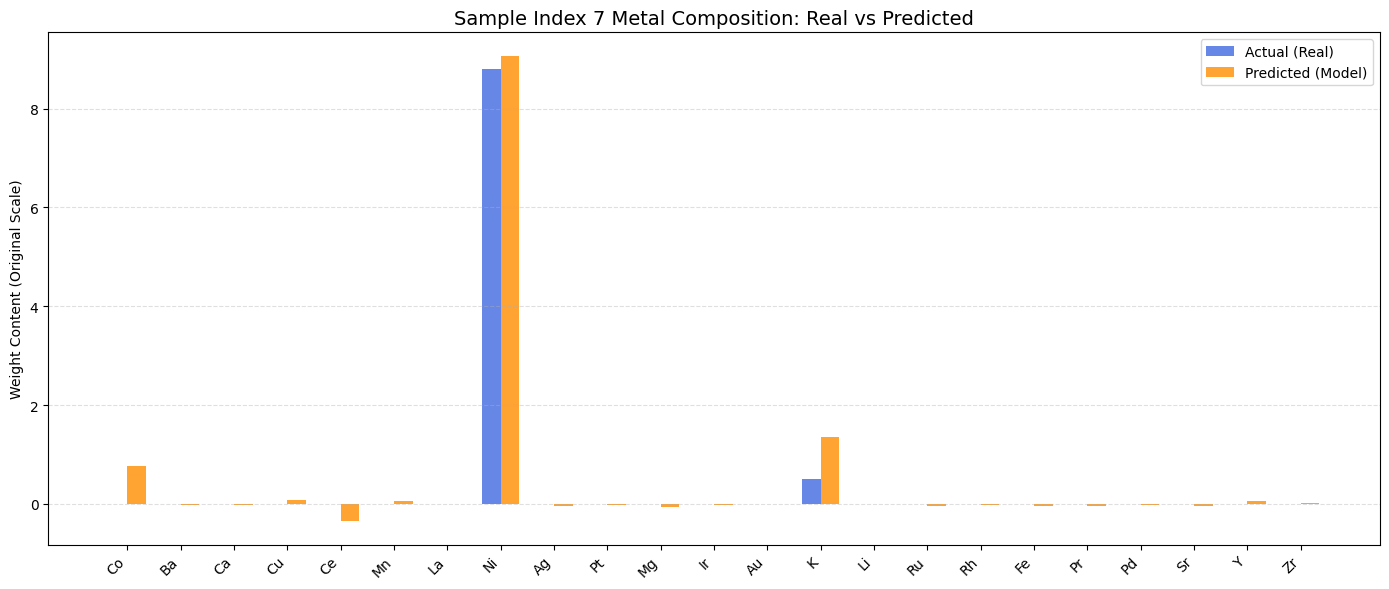

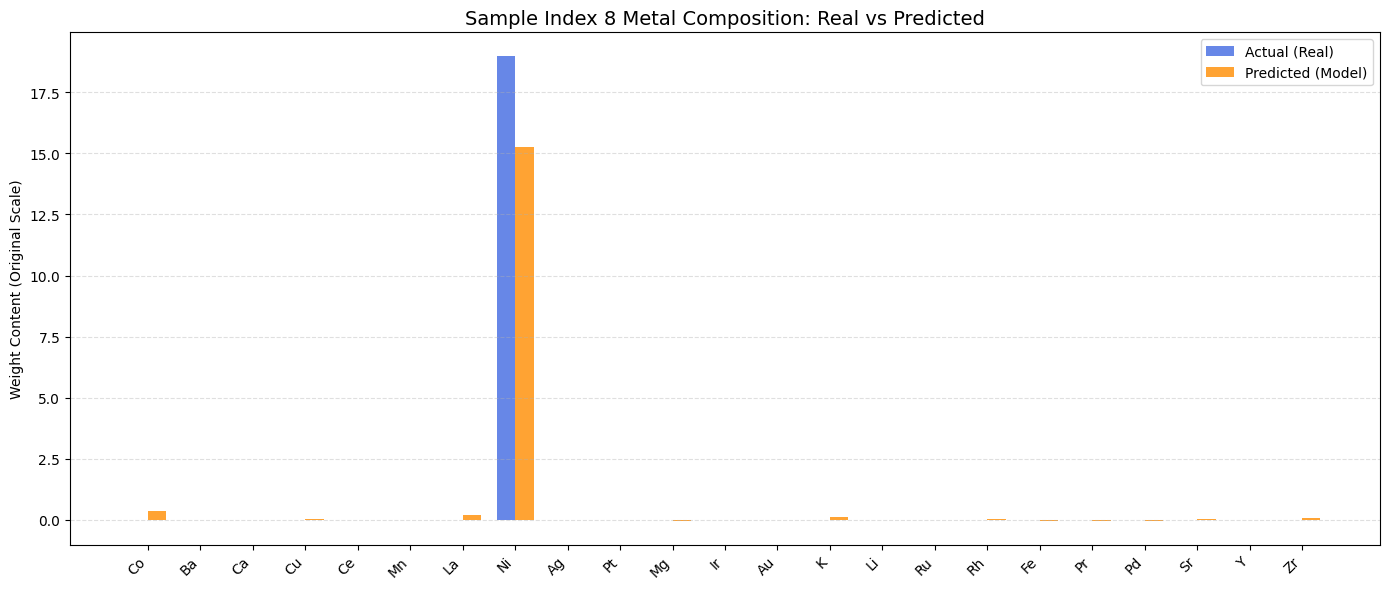

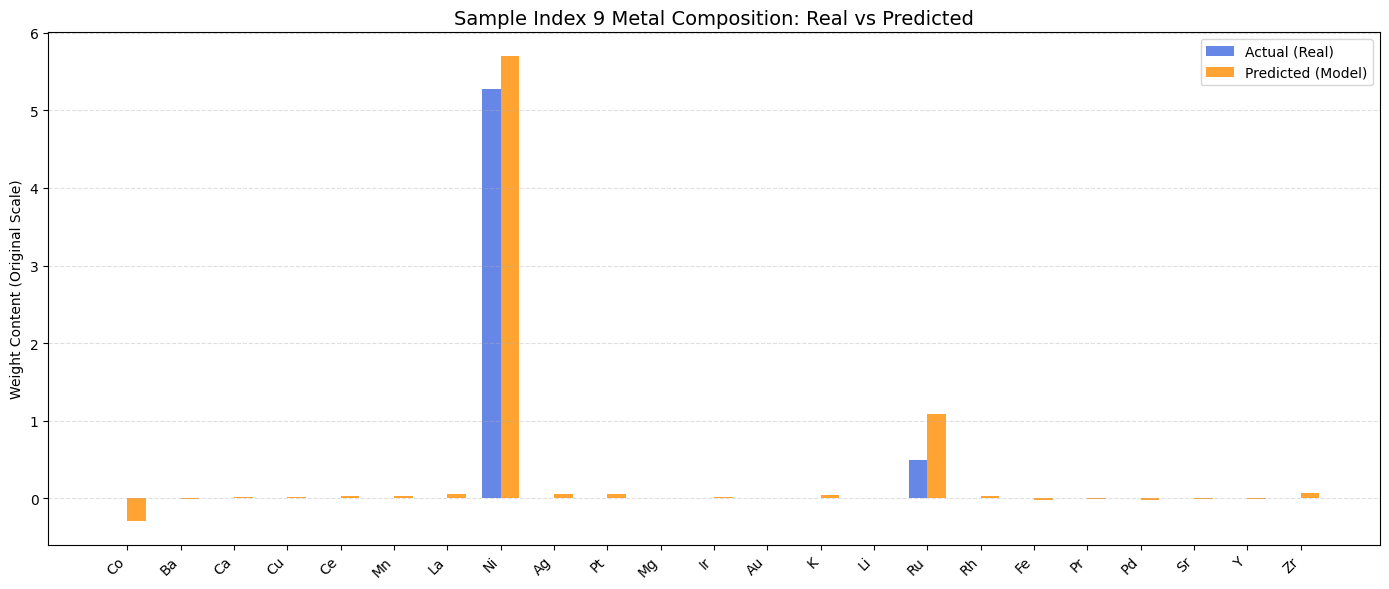

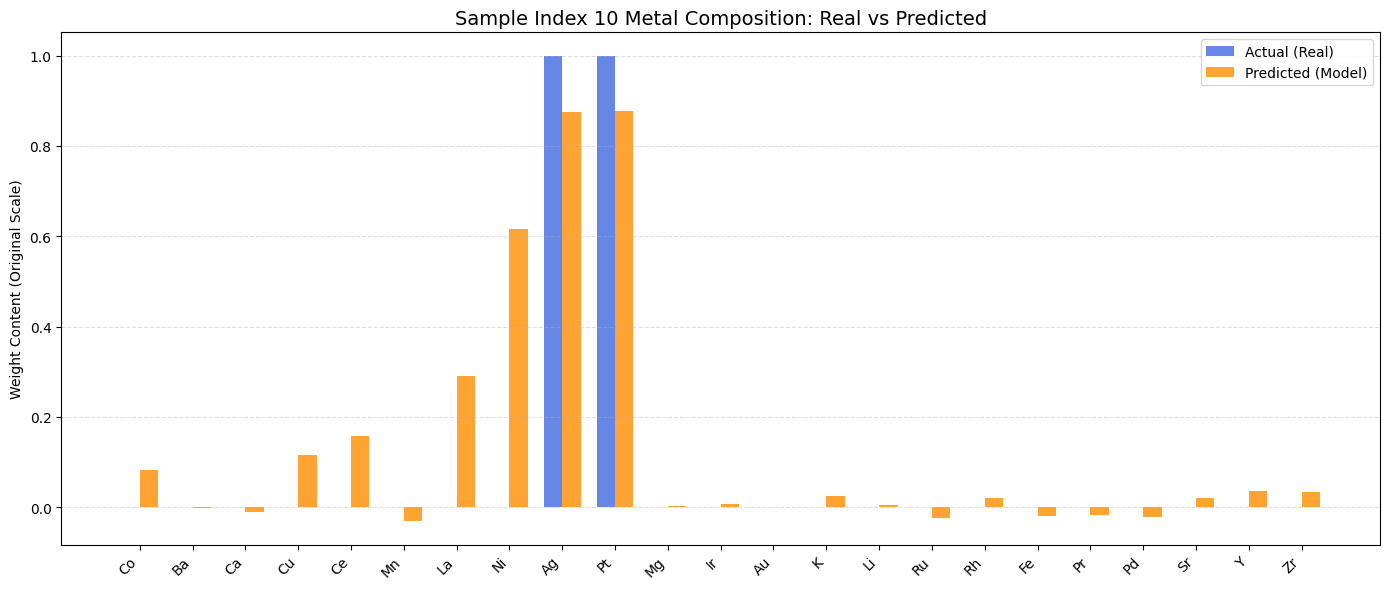

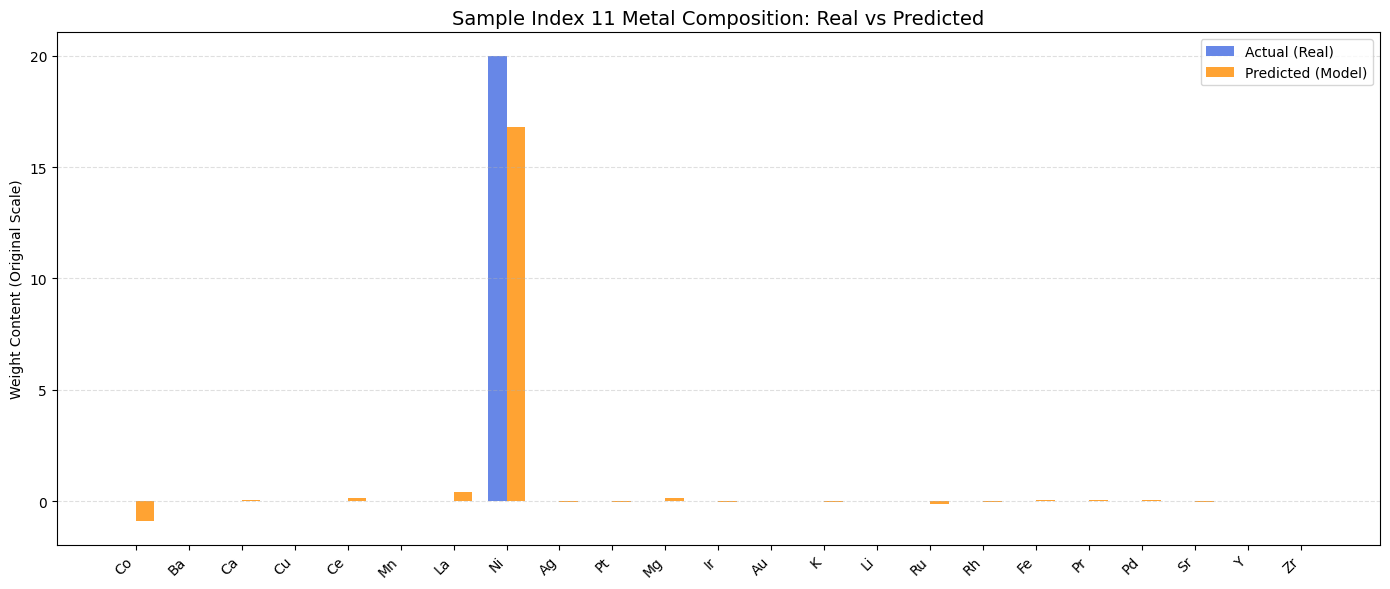

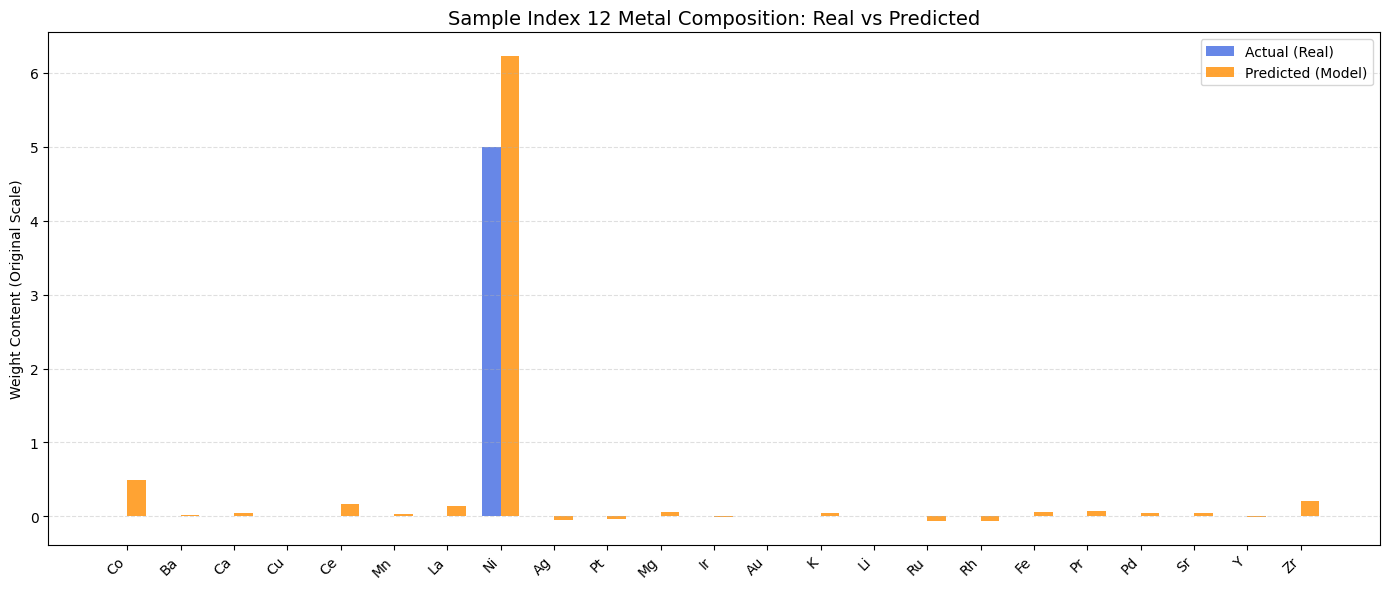

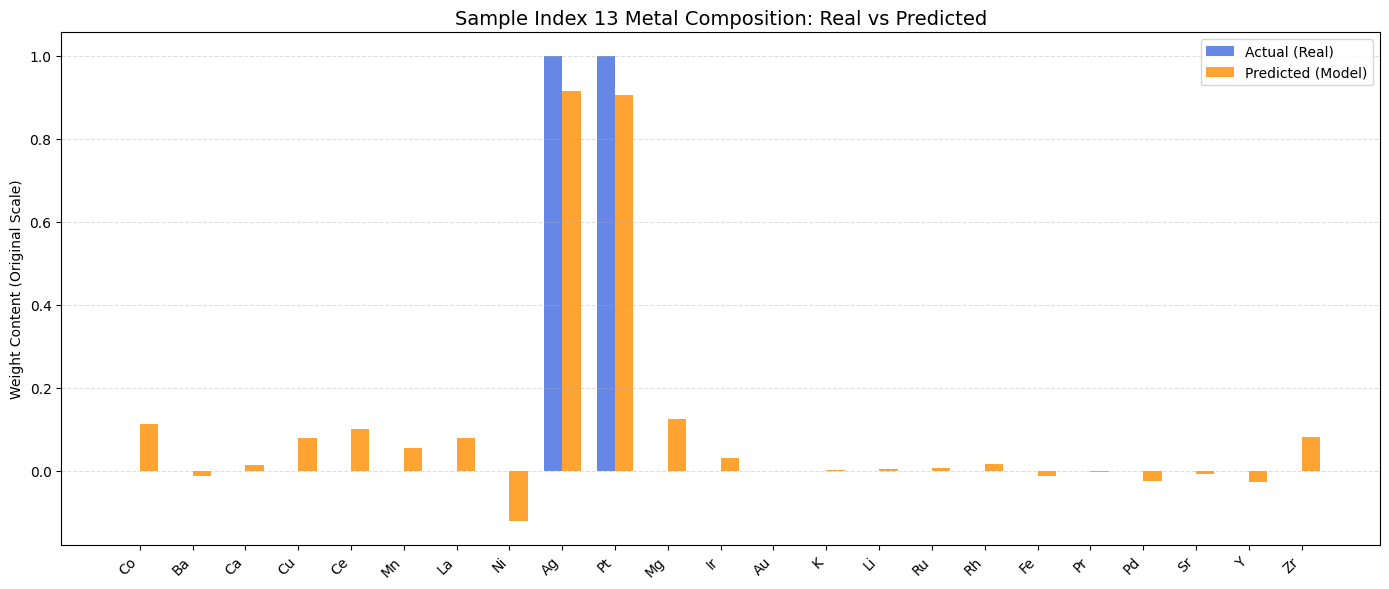

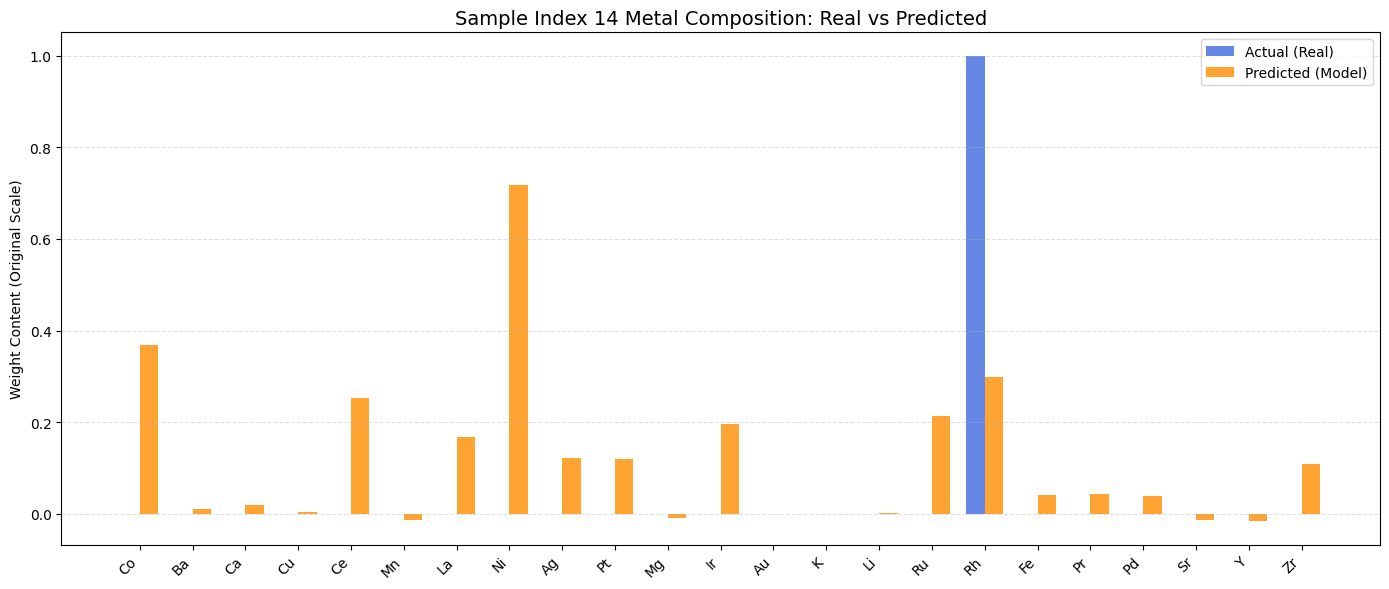

In [ ]:
df_meta = pd.read_csv('211210-DRM-total.csv')
df_metal = df_meta.iloc[:,2:25]
metal_columns = df_metal.columns
for i in range(5, 15):
    plt.figure(figsize=(14, 6))
    x_axis = np.arange(23)
    width = 0.35
    
    plt.bar(x_axis - width/2,x_true_raw[i], width, label='Actual (Real)', color='royalblue', alpha=0.8)
    plt.bar(x_axis + width/2, x_hat_raw[i], width, label='Predicted (Model)', color='darkorange', alpha=0.8)
    
    plt.xticks(x_axis, metal_columns, rotation=45, ha='right')
    plt.title(f'Sample Index {i} Metal Composition: Real vs Predicted', fontsize=14)
    plt.ylabel('Weight Content (Original Scale)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()